In [ ]:
# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('./MyDrive')

In [ ]:
cd MyDrive/MyDrive/Capstone/code_data

# Libraries

In [70]:
import pandas as pd
import numpy as np
from glob2 import glob
import json

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim
import gensim.models.word2vec as w2v
from gensim.test.utils import common_texts
from datetime import datetime
from datetime import date
from datetime import timedelta

from nltk import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import emoji


[nltk_data] Downloading package punkt to /Users/june/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/june/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [71]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 400)
# pd.set_option('display.max_rowwidth', 100)
pd.set_option('display.max_colwidth', 200)

# Functions

In [74]:
lmt = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
freqdist = nltk.FreqDist()
stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer()

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not'), 
                         (r'i\'d', 'i would'), (r'I\'d', 'I would'), (r'he\'d', 'he would'), (r'she\'d', 'she would'), (r'they\'d', 'they would'), (r'we\'d', 'we would')]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def capitalratio(tweet_text):
    uppers = [l for l in tweet_text if l.isupper()]
    capitalratio = len(uppers) / len(tweet_text)
    return capitalratio 

def getTokenization(sent):
    tweet_tokens = []
    sent = sent.lower()
    sent = replaceContraction(sent)

    sent = re.sub(r"http\S+", "*", sent) # http link -> '*'
    # sent = re.sub(r"@\S+", "@", sent)   # mention -> '@'
    sent = re.sub(r"@[^\s]+", "@", sent)   # mention -> '@'
    sent = re.sub(r"(#)(\S+)", r'\1 \2', sent) 

    sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters
    # sent = re.sub('@[^\s]+','atUser',sent)
    # sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',sent)
    # sent = re.sub(r'#([^\s]+)', r'\1', sent)


    # sent = re.sub('', '', sent.lower())
    # sent = [tweet_tokenizer.tokenize(sent)]
    sent = tweet_tokenizer.tokenize(sent)
    sent = [stemmer.stem(token) for token in sent]
    sent = [lmt.lemmatize(token) for token in sent]

    temp = [token for token in sent if not token in stop_words]
    url=0
    for token in temp:
        if token.startswith('*'):
            url+=1
    # tweet_tokens.append([temp])
    # tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    # df_tokens = pd.DataFrame(tweet_tokens, columns=['token'])
    return temp, url

def extract_urls(entities_dicts):
    if len(entities_dicts) < 1:
        return 0
    if len(entities_dicts) == 1:
        return 1
    if len(entities_dicts) == 2:
        return 2

    # urls = []
    # urls_expanded = []

    # key = 'url'
    # key2 = 'expanded_url'
    # # print(len(entities_dict))
    # for i in entities_dicts:
    #     urls.append(i[key])
    #     urls_expanded.append(i[key2])
    # return 1, urls, urls_expanded

def getposcount(tokens):
    postag = []
    poscount = {}
    poscount['Noun']=0
    poscount['Verb']=0
    poscount['Adjective'] = 0
    poscount['Pronoun']=0
    poscount['FirstPersonPronoun']=0
    poscount['SecondPersonPronoun']=0
    poscount['ThirdPersonPronoun']=0
    poscount['Adverb']=0
    poscount['Numeral']=0
    poscount['Conjunction_inj']=0
    poscount['Particle']=0
    poscount['Determiner']=0
    poscount['Modal']=0
    poscount['Whs']=0
    Nouns = {'NN','NNS','NNP','NNPS'}
    Adverbs = {'RB','RBR','RBS'}
    Whs = {'WDT','WP','WRB'} # Composition of wh-determiner(that,what), wh-pronoun(who), wh-adverb(how)
    Verbs={'VB','VBP','VBZ','VBN','VBG','VBD','To'}
    first_person_pronouns=['i','I','me','my','mine','we','us','our','ours'] #'i',
    second_person_pronouns=['you','your','yours', 'ya']
    third_person_pronouns=['he','she','it','him','her','it','his','hers','its','they','them','their','theirs']

    for word in tokens:
        w_lower=word.lower()
        if w_lower in first_person_pronouns:
            poscount['FirstPersonPronoun']+=1
        elif w_lower in second_person_pronouns:
            poscount['SecondPersonPronoun']+=1
        elif w_lower in third_person_pronouns:
            poscount['ThirdPersonPronoun']+=1
    
    postag = nltk.pos_tag(tokens)
    for g1 in postag:
        if g1[1] in Nouns:
            poscount['Noun'] += 1
        elif g1[1] in Verbs:
            poscount['Verb']+= 1
        elif g1[1]=='ADJ'or g1[1]=='JJ':
            poscount['Adjective']+=1
        elif g1[1]=='PRP' or g1[1]=='PRON' or g1[1]=='PRP$':
            poscount['Pronoun']+=1
        elif g1[1] in Adverbs or g1[1]=='ADV':
            poscount['Adverb']+=1
        elif g1[1]=='CD':
            poscount['Numeral']+=1
        elif g1[1]=='CC' or g1[1]=='IN':
            poscount['Conjunction_inj']+=1
        elif g1[1]=='RP':
            poscount['Particle']+=1
        elif g1[1]=='MD':
            poscount['Modal']+=1
        elif g1[1]=='DT':
            poscount['Determiner']+=1
        elif g1[1] in Whs:
            poscount['Whs']+=1
    return poscount

def fetchRawText(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/*.json' % (path, event,tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))

    targets = []
    features = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    try:
                        json_data = json.loads(l)
                    except:
                        print (l,"\n\n")
                        break
                    dataEvent.append(json_data)
        print(index, events[index], len(targetEvent), len(dataEvent))
        targets.append(targetEvent)
        features.append(dataEvent)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])

    extracted_features = []

    extracted = []

    for obj_list in features:
        extracted_event = []
        for obj in obj_list:
            output_f = dict()
            output_f['text'] = obj['text']
            urls_dicts = obj['entities']['urls']
            output_f['URLcount'] = extract_urls(urls_dicts)
        
            # print(type(obj['user']))
            # print(obj['user'].contains_key('entities'))
            # if ('url' in obj['user']):
            #     output_f['hasUserURL'] = 1
            #     output_f['user_url'] = 1 if (obj['user']['url'] != None) else 0
            # elif ('entities' in obj['user']):
            #     output_f['user_entity'] = obj['user']['entities']['url']['urls']
            #     # print(obj['user']['entities']['url']['urls'])
            #     output_f['user_url'] = obj['user']['entities']['expanded_url']
            #     output_f['hasUserURL'] , _ , output_f['user_url'] = extract_urls(obj['user']['entities']['url']['urls'])
            # else:
            #     # output_f['user_entity'] = None
            #     output_f['user_url'] = 0
            #     output_f['hasUserURL'] = 0
            

            output_f['text_token'], output_f['URLcount'] = getTokenization(obj['text'])


            '''POS Tagging and text cleansing for POS'''
            temp = output_f['text']
            temp=  emoji.demojize(temp)
            temp = re.sub(r"(#)(\S+)", r'\1 \2', temp)
            temp = re.sub(r"http\S+", "", temp)
            temp = replaceContraction(temp.lower())
            temp = temp.split()
            pos_dict=getposcount(temp)
            output_f.update(pos_dict)

            output_f['emoji_count'] = emoji.emoji_count(obj['text'])


            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['retweet_count'] = obj['retweet_count']
            output_f['tweet_count'] = np.log10(obj['user']['statuses_count'])
            output_f['listed_count'] = np.log10(obj['user']['listed_count'])
            output_f['friends_count'] = np.log10(obj['user']['friends_count'])
            output_f['follow_ratio'] = np.log10(obj['user']['followers_count'])

            acc_created = datetime.strptime(obj['user']['created_at'], '%a %b %d %H:%M:%S %z %Y')
            tweet_created = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
            age = (tweet_created - acc_created)
            output_f['account_age_days'] = age.days
            
            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['verified'] = obj['user']['verified']

            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    for i, data in enumerate(extracted_features):
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, target], axis=1)
    return final
    

# PHEME

In [15]:
path = "../pheme-rnr-dataset"
events = ['charliehebdo', 'ferguson',
          'germanwings-crash', 'ottawashooting', 'sydneysiege']
tweetType = 'source-tweet'
jsons = []
final = fetchRawText(path, events, tweetType)
target = final.target
final.verified = final.verified.replace({True: 1, False: 0}) 
final.has_question = final.has_question.replace({True: 1, False: 0}) 
final.has_exclaim = final.has_exclaim.replace({True: 1, False: 0}) 
final.has_period = final.has_period.replace({True: 1, False: 0}) 
final = final.replace(-np.inf, 0)


charliehebdo's length is 2079
ferguson's length is 1143
germanwings-crash's length is 469
ottawashooting's length is 890
sydneysiege's length is 1221
0 charliehebdo 2079 2079
1 ferguson 1143 1143
2 germanwings-crash 469 469
3 ottawashooting 890 890
4 sydneysiege 1221 1221


<ipython-input-4-03eea0864855>:228: RuntimeWarning: divide by zero encountered in log10
  output_f['friends_count'] = np.log10(obj['user']['friends_count'])
<ipython-input-4-03eea0864855>:227: RuntimeWarning: divide by zero encountered in log10
  output_f['listed_count'] = np.log10(obj['user']['listed_count'])


In [16]:
final.drop(['text_token','text','Event','target'], axis=1, inplace=True)
final.head()

,URLcount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,HashTag,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,verified
0,1,7,2,0,0,0,0,0,0,0,2,0,0,0,0,0,88,12,0,0,1,0.159091,4.803286,3.855943,2.788168,5.287349,1
1,0,3,2,0,0,0,0,0,0,0,1,0,0,0,0,1,53,6,0,0,1,0.037736,3.031812,2.146128,2.574031,3.672929,0
2,0,4,4,7,0,0,0,0,1,0,2,0,0,0,0,2,136,18,0,0,1,0.073529,3.856245,2.879669,2.772322,4.309651,0
3,2,4,5,1,0,0,0,0,0,0,0,0,2,0,1,1,138,16,0,0,1,0.101449,4.735814,5.009820,3.016197,7.187664,1
4,2,7,2,0,0,0,0,0,0,0,2,0,0,0,0,1,117,13,0,0,1,0.145299,5.021181,4.132996,2.662758,5.925434,1


In [21]:
final.to_csv('./data/_PHEME_sparse.csv', index = False)

# PHEME (Extension)

In [78]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
tweetType = 'source-tweets'
jsons = []
final_ext = fetchRawText(path,events,tweetType)
ext_target = final_ext.target
final_ext.verified = final_ext.verified.replace({True: 1, False: 0}) 
final_ext.has_question = final_ext.has_question.replace({True: 1, False: 0}) 
final_ext.has_exclaim = final_ext.has_exclaim.replace({True: 1, False: 0}) 
final_ext.has_period = final_ext.has_period.replace({True: 1, False: 0}) 
final_ext = final_ext.replace(-np.inf, 0)

ebola-essien's length is 14
prince-toronto's length is 233
putinmissing's length is 238
0 ebola-essien 14 14
1 prince-toronto 233 233
2 putinmissing 238 238


In [76]:
final_ext.drop(['text_token','text','Event','target'], axis=1, inplace=True)
final_ext.head()

,URLcount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,emoji_count,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,retweet_count,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,verified
0,1,2,2,1,0,0,0,0,0,0,1,0,1,0,0,0,69,8,0,0,1,0.10145,117,4.60934,2.17026,2.81425,4.33911,1570,0
1,0,9,6,3,0,2,0,0,3,0,4,0,1,1,0,0,148,25,0,0,1,0.02703,10402,2.70672,3.21032,2.24551,5.68886,579,1
2,0,7,4,1,1,0,0,1,0,0,2,0,3,0,1,0,119,20,0,0,1,0.02521,126,4.92029,3.33546,2.15836,5.36614,2042,0
3,2,5,3,2,0,0,0,0,0,0,1,0,2,0,0,0,130,16,0,0,1,0.10769,192,4.18887,2.78390,2.85491,4.86657,468,1
4,1,4,4,2,0,0,0,0,1,0,2,0,1,0,0,0,120,15,0,0,1,0.06667,196,4.92029,3.33546,2.15836,5.36614,2039,0


In [79]:
final_ext.to_csv('./data/_PHEMEext_sparse.csv', index = False)

# PHEME ALL (Reactions)

## Functions

In [118]:
import pandas as pd
import numpy as np

from glob2 import glob
import json

pd.options.display.float_format = '{:.5f}'.format

def fetchRawText_all(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/[0-9]*.json' % (path, event, tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))

    targets = []
    features = []
    isSrcTweet = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)
            if jsonFile.find("source-tweet") == -1:
                isSrcTweet.append(0)
            else: #if jsonFile.find("reactions") == 1:
                isSrcTweet.append(1)
                

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    json_data = json.loads(l)
                    dataEvent.append(json_data)
        targets.append(targetEvent)
        features.append(dataEvent)
        # isSrcTweet.append(isSrcTweet)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])
    isSrcTweet = pd.DataFrame(isSrcTweet, columns=["isSrcTweet"])

    extracted_features = []

    extracted = []

    for obj_list in features:
        extracted_event = []
        for obj in obj_list:
            output_f = dict()

            if ('text' in obj):
                output_f['text'] = obj['text']
            else:
                output_f['text'] = None
            if ('id' in obj):
                output_f['id'] = obj['id']
            else:
                output_f['id'] = None
            if ('in_reply_to_status_id' in obj):
                output_f['pid'] = obj['in_reply_to_status_id']
            else: 
                output_f['pid'] = None
       
            
            output_f['emoji_count'] = emoji.emoji_count(obj['text'])
            urls_dicts = obj['entities']['urls']
            if "media" in obj['entities']:
                output_f['has_media'] = len(obj['entities']['media'])
                # output_f['media_type'] = obj['entities']['media'][0]['type']
            else:
                output_f['has_media'] = 0
                # output_f['media_type'] = 0
            output_f['URLcount'] = len(urls_dicts)
            # output_f['URLcount'] = extract_urls(urls_dicts)
            # temp = obj['text'].lower()
            temp = re.sub(r"http\S+", "HTTPURL", obj['text'])

            verification = 0
            verification += len(re.findall(r'is(that|this|it) true', obj['text']))
            verification += len(re.findall(r'wh[a]*t[?!|!?][?!|!?]*', obj['text']))
            verification += len(re.findall(r'(rumour|rumor|debunk)', obj['text']))
            verification += len(re.findall(r'(real?|really?|uncomfirmed)', obj['text']))
            verification += len(re.findall(r'(that|this|it) is not true', obj['text']))
            verification += len(re.findall(r'(that|this|it) is false', obj['text']))
            verification += len(re.findall(r'(h[m]*)', obj['text']))
            output_f['Skepticism'] = verification

            url, mention = 0, 0
            for token in temp:
                if token.startswith('HTTPURL'):
                # if token.startswith (r"http\S+"):
                    url+=1
                if token.startswith('@'):
                    mention+=1 
            # output_f['URLcount'] = url
            output_f['MentionCount'] = mention

            '''POS Tagging'''
            temp = output_f['text']
            temp = replaceContraction(temp.lower())
            temp = re.sub(r"(#)(\S+)", '', temp)
            temp = re.sub(r"(@)(\S+)", '', temp)
            temp = re.sub(r"http\S+", "", temp)
            temp = re.sub(r'([^\s\w#\*]|_)+', '', temp) # Erasing Special Characters

            temp = temp.split()
            pos_dict=getposcount(temp)
            output_f['token_for_POS'] = temp
            output_f.update(pos_dict)

            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            # output_f['HashTag'] = len(obj['entities'][0]['hashtags'])
            output_f['HashTag'] = len(obj['entities']['hashtags'])
            
            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['retweet_count'] = obj['retweet_count']
            output_f['isRT'] = obj['retweeted']

            output_f['tweet_count'] = np.log10(obj['user']['statuses_count'])
            output_f['listed_count'] = np.log10(obj['user']['listed_count'])
            output_f['friends_count'] = np.log10(obj['user']['friends_count'])
            output_f['follow_ratio'] = np.log10(obj['user']['followers_count'])
            
            acc_created = datetime.strptime(obj['user']['created_at'], '%a %b %d %H:%M:%S %z %Y')
            tweet_created = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
            age = (tweet_created - acc_created)
            output_f['account_age_days'] = age.days
            output_f['tweet_created'] = datetime.timestamp(tweet_created)
            # output_f['tweet_created2'] = tweet_created
            


            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['verified'] = obj['user']['verified']

            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    # print(events)
    # print(len(extracted_features))
    for i, data in enumerate(extracted_features):
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, isSrcTweet ,target], axis=1)
    final.pid = final.pid
    return final

def depth(x):
    if type(x) is dict and x:
        return 1 + max(depth(x[a]) for a in x)
    if type(x) is list and x:
        return 1 + max(depth(a) for a in x)
    return 0

def getThreadData(path, events):
    import re

    sources = []
    for i, event in enumerate(events):
        sources.append(glob('%s/%s/*/*' % (path, event)))
    roots = []
    children = []
    features = []
    isSrcTweet = []
    for num, event in enumerate(sources):
        for index, dataset in enumerate(event):
            # print(dataset)
            # children.append(glob('%s/reactions/*/*' % (dataset)))
            childs = [os.path.basename(x) for x in glob('%s/reactions/*.json' % (dataset))]
            reext = re.compile(r'(.*?)\.json')
            childs = (reext.match(child) for child in childs)
            children.append([match.group(1) for match in childs if match])
            # print(dataset)
            roots.append(os.path.basename(dataset))

    df = pd.DataFrame(roots, columns=['Root'])
    df = pd.concat([df,pd.DataFrame(children)],axis=1)
    
    structfile = []
    for i, event in enumerate(events):
        structfile.append(glob('%s/%s/**/[0-9]*/structure.json' % (path, event)))

    for i,d in enumerate(structfile): print("%s's structure.json number is %d" %(events[i], len(d)))
    # print(structfile)

    thread_depths = []
    thread_roots = []
    for index, dataset in enumerate(structfile):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            # print(jsonFile)
            match = re.search("/([0-9]*)/", jsonFile)
            # p.match("lalalaI want this partlalala").group(1)
            rootname = match.group(1) if match else None
            # print(rootname)
            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                json_data = json.loads(l)
                # print(json_data)
                thread_depth = depth(json_data)
                thread_depths.append([rootname,thread_depth])
                # thread_roots.append(rootname)
    df_depth = pd.DataFrame(thread_depths, columns=['Root', 'depth'])
    df = pd.merge(df, df_depth, on="Root")
                
    
    # return pd.DataFrame(thread_depths)
    return df

In [81]:
import warnings
warnings.filterwarnings("ignore")

def getThreadInfo(structure, df):
    threadInfo = []
    thread_depth = structure[['Root', 'depth']]
    structure = structure.drop('depth', axis=1)
    for index, data in enumerate(structure.Root):
        tweetInfo = []
        # print("data: %s\n" %(data))
        # print("data: %s\n%s\n" %(data, structure.loc[index,0:].values))
        # print("root: %s\tFirst reaction: %s\n" %(data, structure.loc[index,0]))

        
        pid = int(data)
        thread = structure.loc[structure['Root']==pid].dropna(axis=1)
        # threadRange = structure.loc[structure['Root']==data].any().sum()-1
        # print(structure)
        threadRange = len(structure.iloc[index,:].dropna())

        # 아래로는 성공적인 Features
        friends_count = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        friends_countavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        words_count = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])
        char_count = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['char_count'].values) for childid in structure.loc[index,:].dropna()])
        hashtagavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagpercentage = np.sum([np.any(df.loc[(df['id'] == int(childid))]['HashTag']) for childid in structure.loc[index,:].dropna()])/threadRange
        urlavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        mentionsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionpercentage = np.sum([np.any(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])/threadRange
        verifiedratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        verifiedsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        retweetsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        accageavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])
        accagestd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])
        emojistd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        emojimean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        mediaratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_media'].values) for childid in structure.loc[index,:].dropna()])
        questionratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_question'].values) for childid in structure.loc[index,:].dropna()])
        exclamationratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_exclaim'].values) for childid in structure.loc[index,:].dropna()])
        periodratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_period'].values) for childid in structure.loc[index,:].dropna()])
        FPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        FPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        Skepticismmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])
# FirstPersonPronoun	SecondPersonPronoun	ThirdPersonPronoun

        # Get the lifetime of thread
        # root_created = df.loc[(df['id'] == int(pid))].tweet_created.sum()
        # try:
        #     thread_latest = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created'].values) for childid in structure.loc[index,'0':].dropna()])
        # except:
        # #     print([df.loc[(df['id'] == int(childid))]['tweet_created'].values for childid in structure.loc[index,'0':].dropna()])
        #     print("error")

        # thread_life = thread_latest - root_created
        try:
            thread_life = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - df.loc[(df['id'] == pid)].tweet_created.sum())
        except:
            print("index:", index)

        # 해당 스레드의 트윗 개수
        thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 
        # print("thread_node_count:",thread_node_count,", threadRange:",threadRange, "lastest Thread:", thread_latest )
        # print(structure.loc[structure.Root == data])

        tweetInfo.append(data)
        tweetInfo.append(friends_count)
        tweetInfo.append(friends_countavg)
        tweetInfo.append(words_count)
        tweetInfo.append(char_count)
        tweetInfo.append(hashtagavg)
        tweetInfo.append(hashtagsum)
        tweetInfo.append(hashtagpercentage)
        tweetInfo.append(urlavg)
        tweetInfo.append(urlstd)
        tweetInfo.append(urlratio)
        tweetInfo.append(mentionsum)
        tweetInfo.append(mentionavg)
        tweetInfo.append(mentionpercentage)
        tweetInfo.append(thread_node_count)
        tweetInfo.append(verifiedratio)
        tweetInfo.append(verifiedsum)
        tweetInfo.append(retweetsum)
        tweetInfo.append(retweetavg)
        tweetInfo.append(retweetstd)
        tweetInfo.append(accageavg)
        tweetInfo.append(accagestd)
        tweetInfo.append(thread_life)
        tweetInfo.append(emojistd)
        tweetInfo.append(emojimean)
        tweetInfo.append(mediaratio)
        tweetInfo.append(questionratio)
        tweetInfo.append(exclamationratio)
        tweetInfo.append(periodratio)
        tweetInfo.append(FPPmean)
        tweetInfo.append(FPPstd)
        tweetInfo.append(SPPmean)
        tweetInfo.append(SPPstd)
        tweetInfo.append(TPPmean)
        tweetInfo.append(TPPstd)
        tweetInfo.append(Skepticismmean)

        threadInfo.append(tweetInfo)

        result = pd.DataFrame(threadInfo, columns=['Root', 'SUM FriendsCount','AVG FriendsCount', 'AVG WordCount', 'AVG CharCount', 'AVG HashTag', 'SUM HashTag', 'Ratio HashTag', 'AVG Url','STD Url','RATIO Url','SUM Mention', 'AVG Mention', 'Ratio Mention', 'Tweets Count', 'Ratio Verified','SUM Verified','SUM RT', 'AVG RT','STD RT', 'AVG AccAge', 'STD AccAge', 'thread_time', "STD Emoji","AVG Emoji","Ratio Media",'RATIO Question', 'RATIO Exclaim','RATIO Period', 'AVG FPP','STD FPP','AVG SPP','STD SPP','AVG TPP','STD TPP','AVG Skepticism'])
        # result = pd.merge(thread_depth, result, on="Root").drop(['Root'], axis=1)
    # print(threadInfo)
    return result

In [8]:
len(structure_ext.loc[0,'0':].dropna())

NameError: name 'structure_ext' is not defined

In [435]:
threadRange = len(structure_ext.loc[9,'0':].dropna())
print(threadRange)
print(np.sum([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['HashTag'].values) for childid in structure_ext.loc[9,'0':].dropna()]))
np.sum([np.any(all_ext.loc[(all_ext['id'] == int(childid))]['HashTag'].values) for childid in structure_ext.loc[9,'0':].dropna()])

15
3


3

## PHEME ALL Create

420120 Tweets

In [3]:
# print(pheme_all.shape)
# pheme_all.loc[pheme_all['Event']=='charliehebdo'].shape

In [579]:
path = "../pheme-rnr-dataset"
# events = ['charliehebdo', 'ferguson',
#           'germanwings-crash', 'ottawashooting', 'sydneysiege']
events = ['ottawashooting']
# events = [ 'sydneysiege']

tweetType = '*'
final = fetchRawText_all(path, events, tweetType)
final.verified = final.verified.replace({True: 1, False: 0}) 
final.has_question = final.has_question.replace({True: 1, False: 0}) 
final.has_exclaim = final.has_exclaim.replace({True: 1, False: 0}) 
final.has_period = final.has_period.replace({True: 1, False: 0}) 
final = final.replace(-np.inf, 0)

pheme_all = final

ottawashooting's length is 12284


In [500]:
pheme_all.to_csv('./data/all/_PHEMEall.csv', index = False)

In [582]:
pheme_structure = getThreadData(path, events)
pheme_structure.to_csv('./data/all/_PHEME_structure.csv', index = False)


ottawashooting's structure.json number is 0


## PHEME ALL Process

In [502]:
all_pheme = pd.read_csv("./data/all/_PHEMEall.csv")
structure_pheme = pd.read_csv("./data/all/_PHEME_structure.csv")
print(all_pheme.shape)
print(structure_pheme.shape)

(125208, 34)
(5802, 346)


In [581]:
pheme_thread = getThreadInfo(structure_pheme, all_pheme)
pheme_thread = pheme_thread.fillna(0)
pheme_thread

NameError: name 'structure_pheme' is not defined

In [504]:
pheme_thread.to_csv('./data/all/_PHEME_thread.csv', index = False)


### Data Look

In [580]:
pheme_all.loc[(pheme_all['media_type'] != 0)]['media_type'].value_counts()


photo    942
Name: media_type, dtype: int64

## PHEMEext Create

In [120]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
# events = ['ebola-essien']
tweetType = '*'

all_ext = fetchRawText_all(path, events, tweetType)
all_ext.isRT = all_ext.isRT.replace({True: 1, False: 0}) 
all_ext.verified = all_ext.verified.replace({True: 1, False: 0}) 
all_ext.has_question = all_ext.has_question.replace({True: 1, False: 0}) 
all_ext.has_exclaim = all_ext.has_exclaim.replace({True: 1, False: 0}) 
all_ext.has_period = all_ext.has_period.replace({True: 1, False: 0}) 
all_ext = all_ext.replace(-np.inf, 0)

print(all_ext.shape)
all_ext.head(5)

ebola-essien's length is 226
prince-toronto's length is 902
putinmissing's length is 835
(1963, 42)


,text,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,token_for_POS,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
0,@Mourinholic 😕😕 http://t.co/sFoV1v8uDo,521410632953131008,521369179392581632.00000,2,1,0,2,1,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,3,0,0,0,1,0,0,4.89226,1.20412,3.13799,3.56062,1569,1413148956.00000,0.10526,0,ebola-essien,0,1
1,“@Mourinholic: Micheal Essien denying the Ebola rumours like https://t.co/8Yo8iLgISS”,521373142347153409,521369179392581632.00000,0,0,1,5,1,"[micheal, essien, denying, the, ebola, rumours, like]",2,2,1,0,0,0,0,0,0,1,0,1,0,0,85,9,0,0,0,1,0,0,3.58827,0.90309,3.10072,3.10653,242,1413140018.00000,0.10588,0,ebola-essien,0,1
2,@Mourinholic Hmmm.,521369380249432064,521369179392581632.00000,0,0,0,1,1,[hmmm],1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,2,0,0,0,1,0,0,4.52289,1.17609,1.89209,3.14426,653,1413139121.00000,0.11111,0,ebola-essien,0,1
3,"@Mourinholic Even though it was against us, it was a bloody amazing goal.",521370496928337920,521369179392581632.00000,0,0,0,3,1,"[even, though, it, was, against, us, it, was, a, bloody, amazing, goal]",1,2,2,3,1,0,2,1,0,2,0,1,0,0,73,13,0,0,0,1,0,0,2.96755,0.00000,2.35025,1.75587,1762,1413139387.00000,0.02740,0,ebola-essien,0,1
4,@CdtChoco1er thanks bro.,521370224256614400,521370061550809088.00000,0,0,0,2,1,"[thanks, bro]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,24,3,0,0,0,1,0,0,4.62381,2.20140,2.82607,4.35601,1570,1413139322.00000,0.08333,0,ebola-essien,0,1


In [63]:
all_ext.to_csv('./data/all/_PHEMEextall.csv', index = False)

In [11]:
import os
# ext_structure = getThreadData(path, events)
structure_ext = getThreadData(path, events)

ebola-essien's structure.json number is 14
prince-toronto's structure.json number is 233
putinmissing's structure.json number is 238


In [12]:
structure_ext.to_csv('./data/all/_PHEMEext_structure.csv', index = False)

## PHEME EXT PROCESS
---

In [119]:
all_ext = pd.read_csv("./data/all/_PHEMEextall.csv")
structure_ext = pd.read_csv("./data/all/_PHEMEext_structure.csv")
ext_y = pd.read_csv('./data/_PHEMEext_target.csv')
print(all_ext.shape)
print(structure_ext.shape)

(1963, 43)
(485, 28)


### 👇 Thread 정보만을 추출한 결과
아래의 Features들은 모두 한 Root 트윗에 달린 Thread의 정보를 포함한다.

---

In [132]:
# SUM FriendsCount	AVG FriendsCount 들이 -inf 값 포함
ext_thread = getThreadInfo(structure_ext, all_ext)
# ext_thread = ext_thread.replace(-np.inf, 0)
ext_thread = ext_thread.fillna(0)
ext_thread = ext_thread.replace(-np.inf, 0)
ext_thread.head(15)
ext_thread.to_csv('./data/_PHEMEext_thread.csv', index = False)

In [133]:
ext_thread.describe()

,Root,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,AVG Url,STD Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,STD RT,AVG AccAge,STD AccAge,thread_time,STD Emoji,AVG Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,STD FPP,AVG SPP,STD SPP,AVG TPP,STD TPP,AVG Skepticism
count,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000
mean,552503400071557312.00000,7.61952,1.91587,10.01375,69.41844,0.59794,1.25361,0.29762,0.22614,0.10124,0.22078,3.59381,0.60497,0.40513,4.04742,0.06684,0.15258,40.95258,4.41943,9.69219,986.42153,370.60815,15581.70722,0.06312,0.03985,0.13214,0.15139,0.10150,0.52345,0.18014,0.19884,0.06492,0.06322,0.24703,0.20441,2.26836
std,23774883756088644.00000,9.62440,1.05029,6.36584,42.83633,0.96245,1.75798,0.39206,0.37453,0.18859,0.35968,6.05126,0.66793,0.35595,4.83785,0.21699,0.38759,482.16712,25.62266,107.48288,709.21957,392.53652,51235.86482,0.25042,0.20250,0.29372,0.28140,0.21562,0.38458,0.33362,0.35683,0.22990,0.16169,0.40823,0.32968,1.75281
min,521310417696858112.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,529697032659673088.00000,2.48855,1.31377,5.50000,39.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,475.66667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.16667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
50%,529778109290012672.00000,3.79844,2.07485,10.00000,69.53333,0.04167,1.00000,0.04167,0.00000,0.00000,0.00000,1.00000,0.50000,0.50000,2.00000,0.00000,0.00000,3.00000,2.00000,0.00000,938.46154,209.00000,561.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000
75%,576641067317096448.00000,9.19258,2.70672,15.00000,104.00000,1.00000,2.00000,0.50000,0.33333,0.00000,0.33333,4.00000,1.00000,0.66667,5.00000,0.00000,0.00000,8.00000,4.00000,2.49444,1443.00000,726.71193,6964.00000,0.00000,0.00000,0.05556,0.16667,0.11111,1.00000,0.25000,0.40000,0.00000,0.00000,0.40000,0.43301,3.00000
max,577342598592901120.00000,57.40306,4.38684,29.00000,143.00000,6.00000,12.00000,1.00000,2.00000,0.94281,1.00000,38.00000,6.50000,1.00000,27.00000,1.00000,3.00000,10415.00000,548.15789,2322.57324,3021.00000,1432.00000,753999.00000,2.76385,3.00000,1.00000,1.00000,1.00000,1.00000,2.00000,2.00000,2.00000,1.00000,2.00000,2.00000,9.00000


In [106]:
# all_ext.loc[(all_ext['pid'] == 521369179392581632) | (all_ext['id'] == 521369179392581632)]#[['tweet_created', 'pid', 'id']]
# 521369179392581632

In [124]:
all_ext.loc[(all_ext['pid'] == int(521367917322338304))].head()

,text,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,token_for_POS,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
15,@MichaelEssien Glad you are healthy and well! #ForzaMilan,521368486053150721,521367917322338304.00000,0,0,0,3,1,"[glad, you, are, healthy, and, well]",1,1,1,1,0,1,0,1,0,1,0,0,0,0,57,8,1,0,1,0,0,0,4.59222,2.09342,2.99782,3.52840,2118,1413138908.00000,0.08772,0,ebola-essien,0,1
16,@MichaelEssien that's a shame wanted to Invest in you😔,521368752135610368,521367917322338304.00000,1,0,0,3,1,"[that, is, a, shame, wanted, to, invest, in, you]",1,3,0,1,0,1,0,0,0,1,0,2,0,0,54,9,0,0,0,0,2,0,4.86344,0.69897,2.75282,4.02057,342,1413138971.00000,0.05556,0,ebola-essien,0,1
18,@MichaelEssien u got kik?,521368597734912000,521367917322338304.00000,0,0,0,1,1,"[u, got, kik]",1,1,1,0,0,0,0,0,0,0,0,0,0,0,25,4,0,1,0,0,1,0,4.66114,0.47712,1.99123,3.22968,512,1413138934.00000,0.08000,0,ebola-essien,0,1
20,@MichaelEssien love you mikey,521368183358648321,521367917322338304.00000,0,0,0,1,1,"[love, you, mikey]",1,1,0,1,0,1,0,0,0,0,0,0,0,0,29,4,0,0,0,0,1,0,4.30604,0.77815,2.91698,3.28488,489,1413138836.00000,0.06897,0,ebola-essien,0,1
21,@MichaelEssien pleased to hear it. Nasty rumour,521368281526321152,521367917322338304.00000,0,0,0,3,1,"[pleased, to, hear, it, nasty, rumour]",1,1,2,1,0,0,1,0,0,0,0,0,0,0,47,7,0,0,0,1,0,0,4.27240,0.60206,2.64836,2.42325,866,1413138859.00000,0.06383,0,ebola-essien,0,1


#### BERT & EMOJI 이모지 다루는 차이 😂😂😂😂😂

> Before applying fastBPE to the pre-training corpus of 850M English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets. BERTweet provides this pre-processing step by enabling the normalization argument.



In [312]:
import torch
from transformers import AutoModel, AutoTokenizer 
bertweet = AutoModel.from_pretrained("vinai/bertweet-base", )

# For transformers v4.x+: 
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=False)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [404]:
# INPUT TWEET IS ALREADY NORMALIZED!
line = "@MichaelEssien that's a shame wanted to Invest in you😔"
print(line)
print(tokenizer.encode(line),"\n")
input_ids = torch.tensor([tokenizer.encode(line)])
# print(input_ids)

line = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you pensive_face face_with_tears_of_joy face_with_tears_of_joy :grinning_face_with_big_eyes: HTTPURL  "
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line))


# with torch.no_grad():
#     features = bertweet(input_ids)  # Models outputs are now tuples
# print(features)

@MichaelEssien that's a shame wanted to Invest in you😔
[0, 5238, 55508, 471, 10424, 818, 6139, 20, 11, 2536, 588, 9, 22630, 16, 3805, 3, 2] 

HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com
[0, 10, 5238, 55508, 471, 10424, 818, 6139, 20, 11, 2536, 588, 9, 22630, 27227, 3969, 16, 3805, 3, 3, 3, 45565, 36110, 9485, 17048, 6354, 2] 

HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL
[0, 10, 5, 6139, 20, 11, 2536, 588, 9, 22630, 27227, 3969, 16, 3805, 3, 524, 9859, 1043, 3, 3, 16517, 1043, 88, 10, 2] 

HTTPURL @USER that's a shame wanted to Invest INVEST in you pensive_face face_with_tears_of_joy face_with_tears_of_joy :grinning_face_with_big_eyes: HTTPURL  
[0, 10, 5, 6139, 20, 11, 2536, 588, 9, 22630, 27227, 3969, 16, 14, 581, 62983, 524, 363, 3, 3, 3194, 3, 3, 3194, 3475, 10, 2]


In [871]:
text = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂😃 http://www.google.com"
print(emoji.emoji_count(text),"\n")
print(text)
text = emoji.demojize(text)
# print(emoji.get_emoji_regexp(),"\n")
# text=text.strip(':')
# text = re.sub(r'(@.*?)[\s]', '@USER ', text)
text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
emojis = re.findall(r'(::)', text)
print(emojis)
# print(text,"\n")
text = re.sub(r':[^:]*:', r' \g<0>', text)  # http link -> '*'
print(text,"\n")

text=text.split()
# text= re.sub(r'(:[!_\-\w]+:)', '', text)
print(text,"\n")
# emojis

4 

HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂😃 http://www.google.com
['::', '::', '::']
HTTPURL @USER that's a shame wanted to Invest INVEST in you :pensive_face: :face_with_tears_of_joy: :face_with_tears_of_joy: :grinning_face_with_big_eyes: HTTPURL 

['HTTPURL', '@USER', "that's", 'a', 'shame', 'wanted', 'to', 'Invest', 'INVEST', 'in', 'you', ':pensive_face:', ':face_with_tears_of_joy:', ':face_with_tears_of_joy:', ':grinning_face_with_big_eyes:', 'HTTPURL'] 



#### 추가 데이터들

In [788]:
# all_ext.loc[(all_ext['Whs'] > 1)][['text','token_for_POS','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun','Numeral','Modal','Whs', 'Noun', 'Verb','Adjective','has_question',	'has_exclaim',	'has_period','target']]

In [122]:
all_ext.loc[(all_ext['id'] == int(529657433866915840))].HashTag.values[0]

2

In [125]:
all_ext.loc[(all_ext['pid'] == int(521367917322338304))][['text','token_for_POS','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun','Numeral','Modal','Whs', 'Noun', 'Verb','Adjective','has_question',	'has_exclaim',	'has_period']]

,text,token_for_POS,HashTag,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Numeral,Modal,Whs,Noun,Verb,Adjective,has_question,has_exclaim,has_period
15,@MichaelEssien Glad you are healthy and well! #ForzaMilan,"[glad, you, are, healthy, and, well]",1,1,0,1,0,0,0,0,1,1,1,0,1,0
16,@MichaelEssien that's a shame wanted to Invest in you😔,"[that, is, a, shame, wanted, to, invest, in, you]",0,1,0,1,0,0,0,0,1,3,0,0,0,0
18,@MichaelEssien u got kik?,"[u, got, kik]",0,0,0,0,0,0,0,0,1,1,1,1,0,0
20,@MichaelEssien love you mikey,"[love, you, mikey]",0,1,0,1,0,0,0,0,1,1,0,0,0,0
21,@MichaelEssien pleased to hear it. Nasty rumour,"[pleased, to, hear, it, nasty, rumour]",0,1,0,0,1,0,0,0,1,1,2,0,0,1
22,@MichaelEssien we love you Michael,"[we, love, you, michael]",0,2,1,1,0,0,0,0,0,2,0,0,0,0
23,@MichaelEssien Great to hear Essien !,"[great, to, hear, essien]",0,0,0,0,0,0,0,0,1,1,1,0,1,0
24,@MichaelEssien sue the journalist Michael.,"[sue, the, journalist, michael]",0,0,0,0,0,0,0,0,2,1,0,0,0,1
25,@MichaelEssien @Mourinholic very good to hear bison :) all the best and keep well! 😃,"[very, good, to, hear, bison, all, the, best, and, keep, well]",0,0,0,0,0,0,0,0,2,2,1,0,1,0
27,@MichaelEssien great to hear!,"[great, to, hear]",0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [888]:
# all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]
all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]

,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,HashTag,char_count,word_count,has_question,has_exclaim,has_period,retweet_count,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,isSrcTweet
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,575843532725041152.00000,576128013291619328.00000,0.03099,0.19155,0.13521,0.02254,1.07606,3.14930,2.40845,0.98873,0.71549,0.27887,0.12958,0.45352,0.78310,0.11549,1.39155,0.05352,0.80845,0.19155,0.20563,0.00000,90.39155,13.25915,0.14648,0.14648,0.65634,5.15775,3.80007,1.22078,2.65681,2.73380,1220.76901,1426126771.01972,0.07439,0.01690,0.32676
1,542766681617367296.00000,541958240233241280.00000,0.09453,0.10137,0.20833,0.07090,1.30659,3.57090,2.36567,0.87811,0.64614,0.35012,0.10883,0.37873,0.70647,0.12251,1.27923,0.07276,0.78420,0.20336,0.17600,0.00062,88.37935,12.96144,0.19652,0.18408,0.62624,15.25995,3.86143,1.17609,2.68354,2.89444,1313.23881,1418240635.17226,0.09286,0.07525,0.22948


In [895]:
pd.concat([ext_thread, ext_y], axis=1).groupby('target').mean() 

,Root,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,AVG Url,STD Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,STD RT,AVG AccAge,STD AccAge,thread_time,STD Emoji,AVG Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,STD FPP
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,575085752669624256.00000,6.27038,2.10176,10.91659,77.15702,0.00000,0.00000,0.00000,0.17880,0.06735,0.17757,2.50862,0.48479,0.35553,3.06034,0.01466,0.02586,10.97414,3.75976,3.26869,1049.38342,293.74990,28447.69828,0.02483,0.04061,0.25582,0.15440,0.11342,0.61356,0.24153,0.16274
1,545404340718235008.00000,8.04364,1.85743,9.72992,66.98572,0.00271,0.00271,0.00271,0.24102,0.11189,0.23436,3.93496,0.64275,0.42072,4.35772,0.08324,0.19241,50.37669,4.62681,11.71150,966.62864,394.76956,11537.11382,0.07516,0.03961,0.09326,0.15044,0.09776,0.49512,0.16084,0.21020


In [131]:
all_ext[['id','text','token_for_POS','HashTag','URLcount','target','Skepticism']].loc[all_ext.HashTag > 4]
# all_ext['HashTag'].value_counts()


,id,text,token_for_POS,HashTag,URLcount,target,Skepticism
381,529775890767437825,This is what it sounds like when fans cry. #Prince #Toronto #PRINCEWATCH #princeTOrumours #masseyhall,"[this, is, what, it, sounds, like, when, fans, cry]",5,0,1,5
588,529649691630514176,@blogTO OMG #justsaying #PRINCE #TORONTO #otnorot #MasseyHall #LOVE #PurpleRain,[omg],7,0,1,0
956,529695483661664257,Clearly prince is having a show in #toronto @TorontoComms #tdot #gta #prince #concert http://t.co/e7oktlGd1v,"[clearly, prince, is, having, a, show, in]",5,0,1,3
1156,576860819322880000,Expert: #Vladimir #Putin’s #Disappearance Could Mean #Russia’s Undergoing a #Coup http://t.co/rzLhZFdnwy,"[expert, could, mean, undergoing, a]",5,1,1,2
1212,577300721449771008,@PatDollard @jasian12345 Another Confirmation my readers #SecurityConcerns #Nemstov #Putin Next #Assassination #DrEd https://t.co/n7DQyio1Ej,"[another, confirmation, my, readers, next]",5,1,1,3
1334,577287176288776192,Why the Russian oil crash could threaten Putin with a palace coup - http://t.co/uZIOIWHe4I #WhereIsPutin #putindead #Putin #Kremlin #Moscow,"[why, the, russian, oil, crash, could, threaten, putin, with, a, palace, coup]",5,1,1,8
1341,576890955955113985,@jasian12345 Another Confirmation my readers #SecurityConcerns #Nemstov #Putin Next #Assassination #DrEd https://t.co/n7DQyio1Ej,"[another, confirmation, my, readers, next]",5,1,1,3
1593,577284294051123201,"@patondabak Maybe, just maybe… he's huddling with best minds/top advisors about how to prevent #USA #UK #NATO #EU #Canada threat of WWIII ?","[maybe, just, maybe, he, is, huddling, with, best, mindstop, advisors, about, how, to, prevent, threat, of, wwiii]",5,0,1,6
1614,576175612336992257,"#Putin/s ""death"" or another #maskirovka? Military helo's flying over #Moscow &gt; http://t.co/Spj2VTdlAt #Reddit #Russia #Putindead #NATO","[death, or, another, military, helo, is, flying, over, andgt]",7,1,1,4
1650,577301613502722050,@RT_com #FalseFlag #BlackOps #Ukraine #Flight #MH17 Off Course Flying In #Restricted #Airspace; More https://t.co/9U32Jsfolf,"[off, course, flying, in, more]",7,1,0,2


In [625]:
# np.max([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['tweet_created'].values) for childid in structure_ext.loc[0,'0':].dropna()])
# np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure_ext.loc[0,'0':'13'].dropna()] - all_ext.loc[(all_ext['id'] == int(521369179392581632))].tweet_created.sum())
[np.sum(all_ext.loc[(all_ext['id'] == childid)]['urls_dicts_len']) for childid in structure_ext.loc[11,:].dropna().drop(['depth'],axis=0)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [610]:
# [all_ext.loc[(all_ext['id'] == int(childid))]['URLcount'].values for childid in structure_ext.loc[int(521369179392581632),:].dropna()]

In [214]:
structure_ext.loc[structure_ext.Root == 529723023591743488]
structure_ext

SyntaxError: invalid syntax (<ipython-input-627-1add269d7274>, line 1)

In [67]:
list(ext_thread.thread_time[0])

[array(['2014-10-12 21:22:36+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:38:41+00:00'], dtype=object),
 array(['2014-10-12 18:43:07+00:00'], dtype=object),
 array(['2014-10-12 18:42:02+00:00'], dtype=object),
 array(['2014-10-12 18:44:13+00:00'], dtype=object),
 array(['2014-10-12 19:15:21+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:54:47+00:00'], dtype=object),
 array(['2014-10-12 18:39:06+00:00'], dtype=object),
 array(['2014-10-12 18:41:23+00:00'], dtype=object),
 array(['2014-10-12 18:39:51+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:56:53+00:00'], dtype=object)]

#### Thread()를 만드는데 필요한 정보들

---

In [126]:
all_ext.describe()

,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,isSrcTweet,target
count,1963.00000,1478.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000
mean,548748486071387968.00000,547483663616841984.00000,0.08304,0.11768,0.19511,3.03311,1.26490,3.49465,2.37341,0.89812,0.65869,0.33724,0.11258,0.39226,0.72033,0.12124,1.29954,0.06928,0.78859,0.20122,0.18136,88.74325,13.01528,0.44320,0.18747,0.17728,0.63169,13.43301,3.85033,1.18417,2.67871,2.86539,1296.51605,1419666808.49159,0.08952,0.06470,0.24707,0.81915
std,24197288222753516.00000,24194908479467996.00000,0.52533,0.32231,0.40779,2.08666,0.92597,2.55108,1.83844,0.99326,0.92956,0.72692,0.36411,0.68698,0.98238,0.37989,1.26827,0.26190,0.91239,0.46241,0.44552,39.00655,6.42202,0.98470,0.39039,0.38200,0.48247,254.08308,0.81881,0.92393,0.59617,0.93745,737.28048,5769083.07608,0.07571,0.24605,0.43142,0.38499
min,521310417696858112.00000,521310417696858112.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30103,3.00000,1413125063.00000,0.00000,0.00000,0.00000,0.00000
25%,529676680548595712.00000,529654768249354240.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,55.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.39872,0.47712,2.32118,2.24674,652.00000,1415119735.50000,0.04167,0.00000,0.00000,1.00000
50%,529753935545118720.00000,529735657531656192.00000,0.00000,0.00000,0.00000,3.00000,1.00000,3.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,90.00000,13.00000,0.00000,0.00000,0.00000,1.00000,0.00000,3.94161,1.11394,2.73957,2.82478,1313.00000,1415138155.00000,0.07246,0.00000,0.00000,1.00000
75%,576560832456267776.00000,576504635738951680.00000,0.00000,0.00000,0.00000,4.00000,2.00000,5.00000,4.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,2.00000,0.00000,1.00000,0.00000,0.00000,128.00000,18.00000,0.00000,0.00000,0.00000,1.00000,2.00000,4.43603,1.78174,3.04513,3.39436,2031.00000,1426297788.50000,0.11611,0.00000,0.00000,1.00000
max,579479145828257792.00000,577453947599777792.00000,10.00000,1.00000,2.00000,12.00000,7.00000,21.00000,10.00000,6.00000,5.00000,7.00000,3.00000,5.00000,6.00000,3.00000,7.00000,2.00000,5.00000,3.00000,3.00000,148.00000,29.00000,7.00000,1.00000,1.00000,1.00000,10402.00000,5.73594,4.15927,4.83829,6.31487,3021.00000,1426993569.00000,0.76471,1.00000,1.00000,1.00000


In [536]:
all_ext.loc[all_ext['account_age_days']<100][['account_age_days','verified', 'HashTag', 'URLcount',
                                           'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].value_counts('target')


target
1    71
0    26
dtype: int64

In [57]:
all_ext.loc[(all_ext['retweet_count'] > 0) and (all_ext.pid==521369179392581632)][['verified', 'HashTag', 'URLcount',
                                           'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].sample(18)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [363]:
all_ext.loc[all_ext['retweet_count']>0][['text', 'verified', 'HashTag', 'URLcount', 'MentionCount','retweet_count','target']].groupby('target').mean()

,verified,HashTag,URLcount,MentionCount,retweet_count
target,,,,,
0,0.03356,1.77852,0.65772,0.44966,12.28859
1,0.19880,0.73695,0.73695,0.68273,49.27309


In [832]:
# High degree: If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation. 
# Moderate degree: If the value lies between ± 0.30 and ± 0.49, then it is said to be a medium correlation. 
# Low degree: When the value lies below + . 29, then it is said to be a small correlation.

# ext_thread.corr(ext_y,method='pearson')


In [907]:
for data in ext_thread.columns:
    print(data,":",ext_thread[data].corr(ext_y))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 485 and the array at index 1 has size 1

In [602]:
ext_thread.loc[ext_thread['AVG Url']>0]

,Root,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,AVG Url,SUM Mention,AVG Mention,Ratio Mention,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,STD RT,AVG AccAge,STD AccAge,thread_time,STD Emoji,AVG Emoji,Ratio Media


In [508]:
# (all_ext.loc[(all_ext['pid'] == 521369179392581632)])

In [506]:
ext_thread.to_csv('./data/all/_PHEMEext_thread.csv', index = False)

## Checking the result

In [512]:
pheme_all = pd.read_csv("./data/all/_PHEMEall.csv")
pheme_thread = pd.read_csv("./data/all/_PHEME_thread.csv")
ext_all = pd.read_csv("./data/all/_PHEMEextall.csv")
ext_thread = pd.read_csv("./data/all/_PHEMEext_thread.csv")

In [908]:
# print(pheme_all.shape)
# print(pheme_thread.shape)
# print(ext_all.shape)
print(ext_thread.shape)

(485, 36)


In [134]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


ext_thread = ext_thread.replace(-np.inf, 0)

X_train, X_test, y_train, y_test = train_test_split(ext_thread.iloc[:,:], ext_y, test_size=0.15, random_state=42)


### TRAD

In [135]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [659]:
# ext_thread.isna().sum()
# ext_thread.iloc[:].info()

In [140]:
# 12
clf = SVC()
train_test(X_train[:,0:2], X_test[:,0:2], y_train, y_test, clf)

Accuracy:		 0.684931506849315
Precision Score:	 0.684931506849315
Recall Score:		1.0
F1 Score:		 0.40650406504065034
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.68      1.00      0.81        50

    accuracy                           0.68        73
   macro avg       0.34      0.50      0.41        73
weighted avg       0.47      0.68      0.56        73



In [139]:
#AVG
clf = GaussianNB()
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
train_test(X_train, X_test, y_train, y_test, clf)


Accuracy:		 0.6986301369863014
Precision Score:	 0.868421052631579
Recall Score:		0.66
F1 Score:		 0.685344827586207
              precision    recall  f1-score   support

           0       0.51      0.78      0.62        23
           1       0.87      0.66      0.75        50

    accuracy                           0.70        73
   macro avg       0.69      0.72      0.69        73
weighted avg       0.76      0.70      0.71        73



In [138]:
#STD
clf = LogisticRegression()
# scaler = StandardScaler()
# X_train2 = scaler.fit_transform(X_train.iloc[:,-3:-1:1])
# X_test2 = scaler.transform(X_test.iloc[:,-3:-1:1])
train_test(X_train, X_test, y_train, y_test, clf)

Accuracy:		 0.8493150684931506
Precision Score:	 0.8421052631578947
Recall Score:		0.96
F1 Score:		 0.8075724898154804
              precision    recall  f1-score   support

           0       0.88      0.61      0.72        23
           1       0.84      0.96      0.90        50

    accuracy                           0.85        73
   macro avg       0.86      0.78      0.81        73
weighted avg       0.85      0.85      0.84        73



In [137]:
#STD
clf = RandomForestClassifier()
# scaler = StandardScaler()
# X_train2 = scaler.fit_transform(X_train.iloc[:,-3:-1:1])
# X_test2 = scaler.transform(X_test.iloc[:,-3:-1:1])
train_test(X_train, X_test, y_train, y_test, clf)

Accuracy:		 0.7671232876712328
Precision Score:	 0.7619047619047619
Recall Score:		0.96
F1 Score:		 0.6672030034861893
              precision    recall  f1-score   support

           0       0.80      0.35      0.48        23
           1       0.76      0.96      0.85        50

    accuracy                           0.77        73
   macro avg       0.78      0.65      0.67        73
weighted avg       0.77      0.77      0.73        73



In [136]:
#STD
# clf = RandomForestClassifier()
# clf = GaussianNB()
# clf = SVC()

# scaler = StandardScaler()
# X_train2 = scaler.fit_transform(X_train.iloc[:,-3:-1:1])
# X_test2 = scaler.transform(X_test.iloc[:,-3:-1:1])
train_test(principalComponents, principalComponents_test, y_train, y_test, clf)

NameError: name 'principalComponents' is not defined

In [866]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents)
y_train2 = y_train.reset_index().drop(['index'], axis=1)
finalDf = pd.concat([principalDf, y_train2], axis = 1)
principalComponents_test = pca.fit_transform(X_test)


In [734]:
finalDf

,principal component 1,principal component 2,target
0,-4.14978,-0.97230,1
1,-1.67788,-1.34834,1
2,1.41252,1.13753,0
3,-1.23750,1.80490,1
4,-4.14436,1.09175,0
...,...,...,...
421,1.53700,0.56607,1
422,2.24347,-3.39819,1
423,2.19976,0.22078,1
424,-2.89820,-1.27488,0


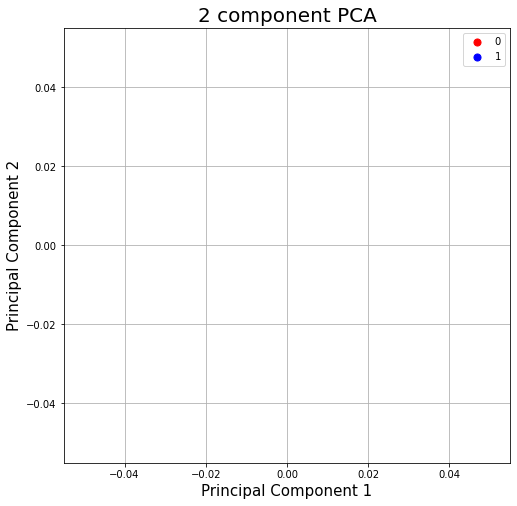

In [739]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0','1']
colors = ['r',  'b']
for target, color in zip(targets,colors):
    indicesToKeep = (finalDf['target'] == target)
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()



### DL

In [141]:
from fetchData import fetchdata 
import __MLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup

In [142]:
X_train.shape, X_test.shape

((412, 36), (73, 36))

In [143]:
# tensor_x1 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
# tensor_x1 = torch.Tensor(X_train.values).unsqueeze(1)
tensor_y1 = torch.Tensor(y_train.values).unsqueeze(1)
tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

# tensor_x2 = torch.Tensor(ext_sparse.values).unsqueeze(1)
# tensor_x2 = torch.Tensor(X_test.values).unsqueeze(1)
tensor_y2 = torch.Tensor(y_test.values).unsqueeze(1)
tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(y_train.values)
labels_weights = 1. / counts
weights = labels_weights[y_train.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

torch.Size([412, 1, 36])
torch.Size([412, 1])
Train Size 412 Test Size 73


In [146]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(36, 10, bias=True) # 420
        self.fc3 = nn.Linear(10, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        x = self.fc3(x)
        return x

In [147]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [148]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-4, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [149]:
def clf_report(train_loss, train_acc, val_loss, val_acc):
    fig, ax = plt.subplots(4, 1, figsize=(12,8))
    ax[0].plot(train_loss[:])
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_acc[:])
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_loss[:])
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Testing Loss')

    ax[3].plot(val_acc[:])
    ax[3].set_ylabel('Classification Accuracy')
    ax[3].set_title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    print("Min of Training Loss: %4f"%(np.min(train_loss)))
    print("Max of Training Accuracy: %4f"%(np.max(train_acc)))
    print("Mean of Training Loss: %4f"%(np.mean(train_loss)))
    print("Mean of Training Accuracy: %4f"%(np.mean(train_acc)))
    print("----")
    print("Max of Testing Accuracy: %4f"%(np.max(val_acc)))
    print("Mean of Testing Loss: %4f"%(np.mean(val_loss_list)))
    print("Mean of Testing Accuracy: %4f"%(np.mean(val_acc)))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train1(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def train2(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            print(inputs.size())
            print(labels.size())
            print(inputs.flatten())
            print(labels.flatten())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            print("outputs:",outputs.size())
            print("outputs:",outputs)
            print("labels:",labels.size())
            print("labels:",labels.unsqueeze(1).size())

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            preds = torch.argmax(outputs, dim=1).flatten()
            # print(outputs.flatten().size())
            # preds = outputs > 0.0
            # labels = labels.view(-1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # print('running correct')
            # print(running_corrects)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    val_preds = torch.argmax(val_outputs, dim=1).flatten()
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs:",val_outputs.flatten())
                    # val_preds = val_outputs > 0.0
                    # print("val_preds:",val_preds)
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds ==
                                              val_label.data).double()
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss/test_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))


In [150]:
import random

train_acc, train_loss, val_acc, val_loss_list = train1(model=model_sparse, num_epochs=epochs,patience=5, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/99	Train) Acc: 0.5461, Loss: 0.6817
		Validation) Acc: 0.6438 Loss:0.6576
		Saving the best model w/ loss 0.6817
		Saving the best model w/ loss 0.6529
Epoch 2/99	Train) Acc: 0.6893, Loss: 0.6344
		Validation) Acc: 0.6712 Loss:0.6370
		Saving the best model w/ loss 0.6344
		Saving the best model w/ loss 0.6104
Epoch 4/99	Train) Acc: 0.7476, Loss: 0.5902
		Validation) Acc: 0.6301 Loss:0.6215
		Saving the best model w/ loss 0.5902
Epoch 6/99	Train) Acc: 0.7816, Loss: 0.5631
		Validation) Acc: 0.6849 Loss:0.6047
		Saving the best model w/ loss 0.5631
Epoch 8/99	Train) Acc: 0.7743, Loss: 0.5493
		Validation) Acc: 0.6849 Loss:0.5905
		Saving the best model w/ loss 0.5493
Epoch 10/99	Train) Acc: 0.7597, Loss: 0.5421
		Validation) Acc: 0.6986 Loss:0.5717
		Saving the best model w/ loss 0.5421
		Saving the best model w/ loss 0.5282
Epoch 12/99	Train) Acc: 0.7718, Loss: 0.5323
		Validation) Acc: 0.7260 Loss:0.5587
Epoch 14/99	Train) Acc: 0.7816, Loss: 0.5158
		Validation) Acc: 0.7397 Lo

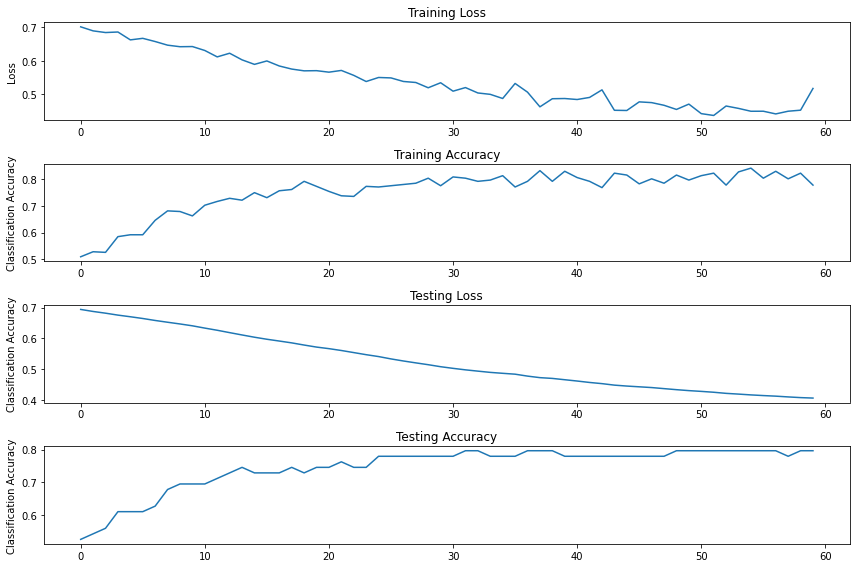

Min of Training Loss: 0.436889
Max of Training Accuracy: 0.840376
Mean of Training Loss: 0.540100
Mean of Training Accuracy: 0.753521
----
Max of Testing Accuracy: 0.796610


NameError: name 'val_loss_list' is not defined

In [829]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)